[iris 데이터셋을 활용한 꽃잎 너비 예측]
- 데이터셋: iris.csv에서 2개의 feature 사용
- 구현 프레임워크: Pytorch

[1] 모듈 로딩 및 데이터 준비

In [149]:
#모듈 로딩
import torch                        #텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               #인공신경망 관련 모듈
import torch.nn.functional as F     #손실함수, 거래함수 등 관련 모듈
import torch.optim as optimizer     #최적화 기법 관련 모듈

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [151]:
#데이터 로딩:  csv -> DataFrame
data_file='../data/iris.csv'
irisDF=pd.read_csv(data_file,usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습 방법: 지도학습 중 회귀
- 알고리즘: 선형모델 (nn.Linear)


In [152]:
#in_features: sepal.length, sepal.width, petal.length 1개
#out_features: petal.width 1개

model=nn.Linear(3,1)

In [153]:
#가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param} \n')

[weight] Parameter containing:
tensor([[-0.4617,  0.4282, -0.2222]], requires_grad=True) 

[bias] Parameter containing:
tensor([0.5024], requires_grad=True) 



[3] 최적화 인스턴스 준비

In [154]:
#모델의 가중치와 절편 최적화하여 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)    #lr=learning rate: 학습 간격

[4] 학습: 개발자가 구현
1) DS Tensor화
- 데이터 준비 시 진행하거나 학습 전 진행
    - 하고싶을 때 하면 된다~~~~~~~

In [155]:
featureTS=torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [156]:
targetTS=torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [167]:
#train-test 분리
x_train,x_test,y_train,y_test=train_test_split(featureTS,targetTS,test_size=0.2)

#train-valid 분리
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2)

print(f'[FEATURE] TRAIN {x_train.shape}, TEST {x_test.shape}, VALIDATE {x_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape}, TEST {y_test.shape}, VALIDATE {y_val.shape}')

[FEATURE] TRAIN torch.Size([96, 3]), TEST torch.Size([30, 3]), VALIDATE torch.Size([24, 3])
[TARGET] TRAIN torch.Size([96, 1]), TEST torch.Size([30, 1]), VALIDATE torch.Size([24, 1])


2) 학습 진행
- 학습 횟수 결정: 에포크 설정
- 학습 결과 저장: 손실 저장 변수 생성

In [157]:
EPOCH=10          #1부터 돌리면서 error 확인하기

In [170]:
#테스트/검증 함수: 최적화(가중치, 절편 업데이트) 진행 X

def testing(testTS,targetTS,kind='val'): 

    with torch.no_grad():       #가중치, 절편 업데이트 진행 X
        #학습 진행 - forward
        pre_y=model(testTS)

        #오차 계산 - 손실함수
        loss=F.mse_loss(pre_y,targetTS)

        #학습 결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}')

    return loss

In [171]:
#모델 학습 함수

def training(featureTS,targetTS,valTS,valTargetTS): 

    loss_history=[[],[]]

    for epoch in range(EPOCH):
        #학습 진행 - forward
        pre_y=model(featureTS)

        #오차 계산 - 손실함수
        loss=F.mse_loss(pre_y,targetTS)
        loss_history[0].append(loss.item())

        #최적화 -  가중치, 절편 업데이트(backward)
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        #검증: 모델이 제대로 만들어지는지 검사하는 용도
        val_loss=testing(valTS,valTargetTS)
        loss_history[1].append(val_loss.item())

        #학습 결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS: {loss}')

    return loss_history

In [172]:
#모델 학습 진행
loss=training(x_train,y_train,x_val,y_val)

[val] LOSS: 0.9835612177848816
[0/10] LOSS: 0.972370445728302
[val] LOSS: 1.1769877672195435
[1/10] LOSS: 1.38715398311615
[val] LOSS: 1.1899126768112183
[2/10] LOSS: 1.6927251815795898
[val] LOSS: 1.008169174194336
[3/10] LOSS: 1.7067512273788452
[val] LOSS: 0.7308681011199951
[4/10] LOSS: 1.4327783584594727
[val] LOSS: 0.4928707182407379
[5/10] LOSS: 1.0091197490692139
[val] LOSS: 0.3936394155025482
[6/10] LOSS: 0.6147574782371521
[val] LOSS: 0.45480597019195557
[7/10] LOSS: 0.38488826155662537
[val] LOSS: 0.6171117424964905
[8/10] LOSS: 0.3605222702026367
[val] LOSS: 0.7765397429466248
[9/10] LOSS: 0.48366332054138184


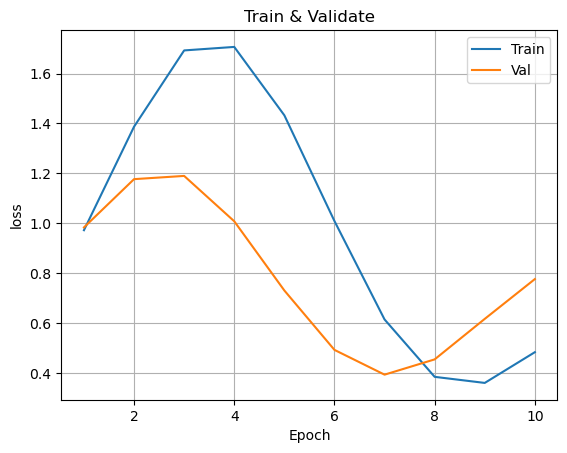

In [173]:
#학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(range(1,11),loss[0],label='Train')     #range: 지정한 epoch에 맞춰서 (1 ~ epoch+1)
plt.plot(range(1,11),loss[1],label='Val')
plt.title('Train & Validate')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()